In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import numpy as np
import glob

In [8]:
image_paths = glob.glob("E:/coro. 1/CutImages/Calcified/*.jpg")

In [9]:
lst = []

for path in image_paths:
    # Load the image
    image = cv2.imread(path)
    lst.append(image)

In [10]:
lst[0].shape

(1024, 1024, 3)

In [106]:
def process_calcified_with_red_mask(image):
    mask = np.where(image > 190, 255, 0).astype(np.uint8)
    _, mask = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY)
    
    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY) if len(mask.shape) == 3 else mask
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    output_image = image.copy()
    if len(output_image.shape) == 2:
        output_image = cv2.cvtColor(output_image, cv2.COLOR_GRAY2BGR)
    
    overlay = output_image.copy()
    letters = string.ascii_lowercase
    
    area_threshold_yellow = 200
    area_threshold_red = 500
    
    for idx, contour in enumerate(contours):
        letter = letters[idx % len(letters)]
        M = cv2.moments(contour)
        if M["m00"] == 0:
            continue
        cx = int(M["m10"] / M["m00"])
        cy = int(M["m01"] / M["m00"])
        
        mask_island = np.zeros_like(mask)
        cv2.drawContours(mask_island, [contour], -1, 255, thickness=-1)
        island_values = image[mask_island == 255]
        island_average = np.mean(island_values)
        island_max = np.max(island_values)
        island_area = cv2.contourArea(contour)
        
        if island_area > 15 and island_max > 240:
            if island_max >= 251 and island_area > 100 and island_average > 230:
                draw_red_mask = True
            else:
                if abs(island_average - island_max) > 40:
                    draw_red_mask = False
                elif abs(island_max - island_average) > 60 and island_max > 240:
                    draw_red_mask = True
                elif abs(island_average - island_max) < 30 and island_max > 230:
                    draw_red_mask = True
                elif island_max <= 230:
                    draw_red_mask = False
                else:
                    draw_red_mask = True
        else:
            draw_red_mask = False
        
        if draw_red_mask:
            color = (0, 255, 0)  # Green by default
            if island_area > area_threshold_red:
                color = (0, 0, 255)  # Red for large areas
            elif island_area > area_threshold_yellow:
                color = (0, 255, 255)  # Yellow for medium areas
            
            cv2.drawContours(overlay, [contour], -1, color, thickness=-1)
            
            # Add bounding box and label
            x, y, w, h = cv2.boundingRect(contour)
            cv2.rectangle(output_image, (x, y), (x + w, y + h), color, 2)
            cv2.putText(output_image, "calcified", (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255,255,0), 3)
    
    alpha = 0.4
    cv2.addWeighted(overlay, alpha, output_image, 1 - alpha, 0, output_image)
    
    return output_image

In [107]:
img = process_calcified_with_red_mask(lst[12])

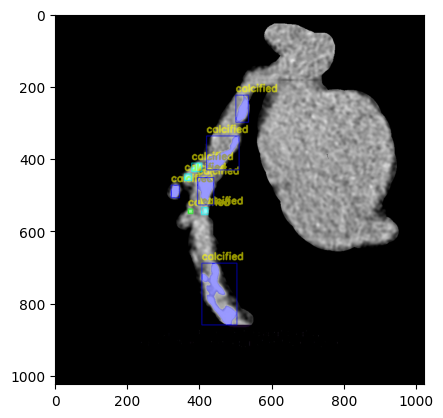

In [108]:
plt.imshow(img)

In [109]:
for i in range(len(lst)):
    img = process_calcified_with_red_mask(lst[i])
    cv2.imwrite(f'path/to/save/__.jpg', img)